# python import 

In [1]:
import os
import pandas as pd
import numpy as np
import lmfit
import glob
import platform
import json

from ipywidgets import interactive
from IPython.core.display import HTML
from IPython.display import display

import ipywidgets as widgets

import pprint

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib notebook

# images size 

In [2]:
image_width = 9576
image_height = 6388
print(f"{image_height/2 =}")
print(f"number of pixels: {image_width * image_height:_}")
print(f"original image is 122MB")

image_height/2 =3194.0
number of pixels: 61_171_488
original image is 122MB


# pixel size 

this has been calculated by the notebook [calculation of pixel size](calculation_of_pixel_size.ipynb)

In [3]:
pixel_size = 51.010e-3  # mm   

# beam size 

In [4]:
beam_diameter_mm = 22.2157e1 # mm
beam_diameter_px = np.round(beam_diameter_mm / pixel_size)
print(f"{beam_diameter_px = }")
beam_radius_px = beam_diameter_px / 2
beam_radius_mm = beam_diameter_mm / 2
print(f"{beam_radius_px = } px")
print(f"{beam_radius_mm = } mm")

beam_diameter_px = 4355.0
beam_radius_px = 2177.5 px
beam_radius_mm = 111.0785 mm


# User input 

Define the **base folder (base_folder)** from where all the data set will be located. 

For example, if you are working on the analysis machine:

*top_folder* = "/SNS/VENUS/IPTS-31716/shared/2023-06-12-analysis/"


In [5]:
if platform.node() == "mac113775":
    top_folder = "/Volumes/JeanHardDrive/SNS/VENUS/IPTS-31716/2023-06-12-analysis/"
elif platform.system() == "Linux":
    top_folder = "/SNS/VENUS/IPTS-31716/shared/2023-06-12-analysis"    
else:
    top_folder = "/Users/j35/SNS/VENUS/IPTS-31716-first_experiment_ever"
    
base_folder = top_folder + "/profiles/beam_center_for_all_apertures"
assert os.path.exists(base_folder)  # making sure the base folder exists

# Loading all the images 

In [6]:
base_folder = top_folder + "/median_data/"
list_images_to_load = glob.glob(os.path.join(base_folder, '*.tif'))
assert len(list_images_to_load) > 0

## DEBUGGING ONLY
list_images_to_load = list_images_to_load[:3]

progress_bar = widgets.IntProgress()
progress_bar.max = len(list_images_to_load)
display(progress_bar)

images = {}
for _image_filename in list_images_to_load:
    _key = os.path.basename(_image_filename)
    image = np.asarray(Image.open(_image_filename))
    images[_key] = image
    progress_bar.value += 1
    
progress_bar.close()
print("All images have been loaded!")

IntProgress(value=0, max=3)

All images have been loaded!


# Interactive selection of profiles 

In [7]:
roi_width = 3

def get_horizontal_profile(image=None, y=1):
    profile_region = image[y-1: y+1, :]
    return np.mean(profile_region, axis=0)    

def get_vertical_profile(image=None, x=1):
    profile_region = image[:, x-1: x+1]
    return np.mean(profile_region, axis=1)

<IPython.core.display.Javascript object>


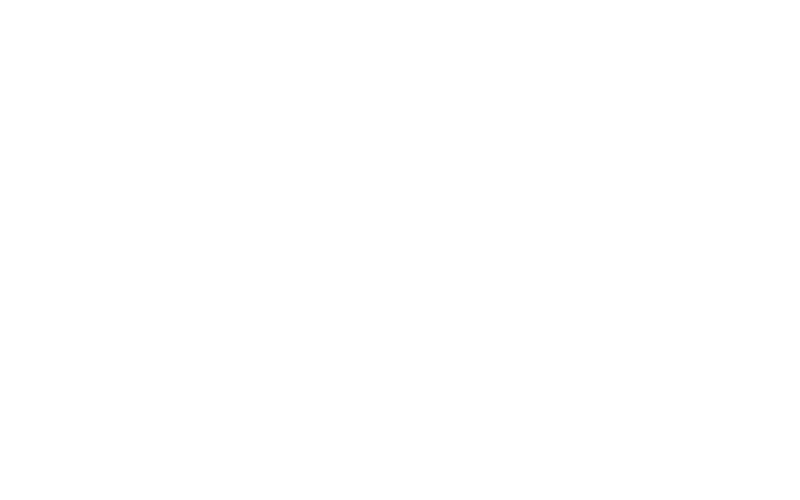

interactive(children=(Dropdown(description='filename', layout=Layout(width='400px'), options=('0deg_30s_frames…

In [8]:
figure = plt.figure(num='visualize image center', figsize=(8, 5))

list_keys = list(images.keys())
image = images[list_keys[0]]
vmin_value = np.min(image)
vmax_value = np.max(image)

def plot_images(filename, vmin, vmax, y, x):
    
    plt.clf()
    
    axis0 = figure.add_subplot(221)
    axis0.clear()
    axis0.imshow(images[filename], vmin=vmin, vmax=vmax)
    axis0.axhline(y, color='red', linestyle='--')
    axis0.axvline(x, color='pink', linestyle='--')

    axis_verti = figure.add_subplot(222)
    axis_verti.clear()
    profile = get_vertical_profile(image=images[filename],
                                  x=x)
    axis_verti.plot(profile)
    axis_verti.set_title(f"Vertical profile (x={x}px)")
    
    axis_hori = figure.add_subplot(223)
    axis_hori.clear()
    profile = get_horizontal_profile(image=images[filename],
                                    y=y)
    axis_hori.plot(profile)
    axis_hori.set_title(f"Horizontal profile (y={y}px)")

    figure.tight_layout()
    
    return y, x, filename
   
v = interactive(plot_images,
               filename = widgets.Dropdown(options=images.keys(),
                                           layout=widgets.Layout(width='400px')),
               y = widgets.IntSlider(min=1,
                                     max=image_height-2,
                                     continuous_update=False),
               x = widgets.IntSlider(min=1,
                                     max=image_width-2,
                                     continuous_update=False),
               vmin = widgets.FloatSlider(min=vmin_value,
                                          max=vmax_value,
                                          value=vmin_value,
                                          continuous_update=False),
                vmax = widgets.FloatSlider(min=vmin_value,
                                           max=vmax_value,
                                           value=vmax_value,
                                           continuous_update=False),
               )
display(v)


# Profile to fit 

<IPython.core.display.Javascript object>


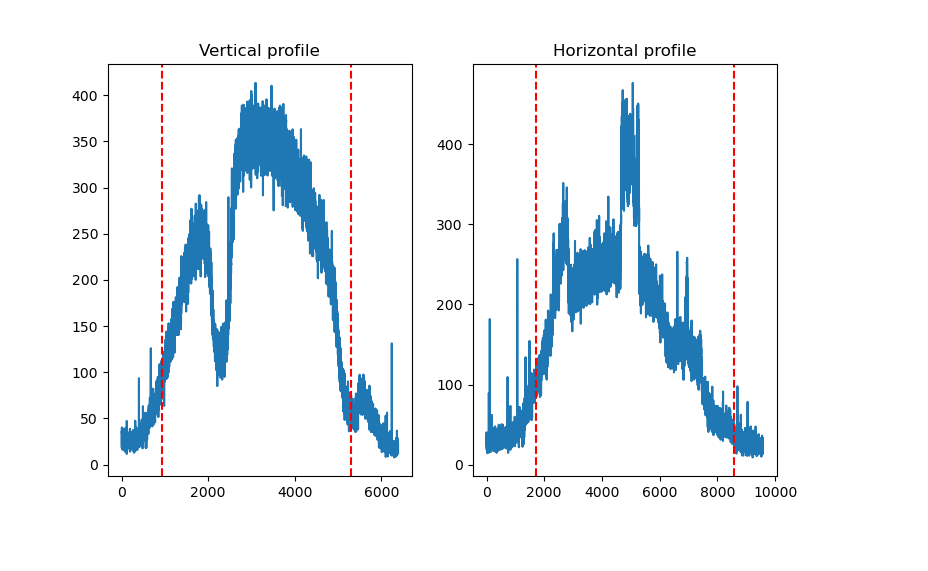

interactive(children=(IntSlider(value=0, continuous_update=False, description='hori_left', max=9575), IntSlide…

In [19]:
y_profile, x_profile, filename = v.result

figure = plt.figure(num=f"Profiles of {filename}", figsize=(8, 5))

vertical_profile = get_vertical_profile(image=images[filename], x=x_profile)
horizontal_profile = get_horizontal_profile(image=images[filename], y=y_profile)

def plot_profiles(hori_left, hori_right, verti_left, verti_right):

    plt.clf()

    axis0 = figure.add_subplot(121)
    axis0.clear()
    axis0.plot(vertical_profile)
    axis0.set_title("Vertical profile")   
    axis0.axvline(verti_left, color='red', linestyle='--')
    axis0.axvline(verti_right, color='red', linestyle='--')

    axis1 = figure.add_subplot(122)
    axis1.clear()
    axis1.plot(horizontal_profile)
    axis1.set_title("Horizontal profile")   
    axis1.axvline(hori_left, color='red', linestyle='--')
    axis1.axvline(hori_right, color='red', linestyle='--')

    
profiles_ui = interactive(plot_profiles,
                          hori_left = widgets.IntSlider(min=0,
                                                  max=len(horizontal_profile)-1,
                                                  value=0,
                                                  continuous_update=False),
                          hori_right = widgets.IntSlider(min=0,
                                                   max=len(horizontal_profile)-1,
                                                   value=len(horizontal_profile)-1,
                                                   continuous_update=False),
                          verti_left = widgets.IntSlider(min=0,
                                                  max=len(vertical_profile)-1,
                                                  value=0,
                                                  continuous_update=False),
                          verti_right = widgets.IntSlider(min=0,
                                                   max=len(vertical_profile)-1,
                                                   value=len(vertical_profile)-1,
                                                   continuous_update=False)
                         )
display(profiles_ui)

